In [61]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve,
                             roc_curve, confusion_matrix, precision_score, recall_score, f1_score)
from joblib import dump
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', '{:.4f}'.format)


In [60]:
from IPython.display import display

data_path = r'/Users/zhixiao/Downloads/creditcard_stratified_3000.xlsx'
df = pd.read_excel(data_path, sheet_name=0)

print("Shape:", df.shape)
display(df.head(3))
print("Class counts:\n", df["Class"].value_counts())
print(f"Fraud rate: {df['Class'].mean()*100:.4f}%")

Shape: (3000, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,109397,-0.7369,1.2624,0.6733,0.3070,0.8402,-1.0268,1.0273,-0.3863,0.7055,...,0.0618,0.4531,-0.6010,-0.1405,0.8801,0.1539,-0.1021,0.0985,33.5600,0
1,76058,1.0591,-0.8120,1.1222,0.3841,-1.0089,0.9838,-0.9871,0.3851,1.4945,...,-0.2011,-0.2589,-0.1657,-0.4060,0.3222,1.0570,-0.0189,0.0085,71.7500,0
2,48345,0.9439,-0.0558,0.4255,0.9774,0.2706,1.3594,-0.3854,0.6221,-0.1030,...,0.1272,0.3904,0.1211,-0.8547,0.1114,-0.3224,0.0763,0.0037,25.0000,0


Class counts:
 Class
0    2995
1       5
Name: count, dtype: int64
Fraud rate: 0.1667%


The output shows a dataset with 3,000 rows and 31 columns: 30 features (Time, V1–V28, Amount) and one target label, Class (1 = fraud, 0 = legitimate). The head preview lists typical values for these fields—Time is seconds since the first transaction, V1–V28 are PCA-transformed anonymized features, and Amount is the transaction value. The class counts reveal 2,995 legitimate and 5 fraudulent transactions, i.e., a fraud rate of 0.1667%.

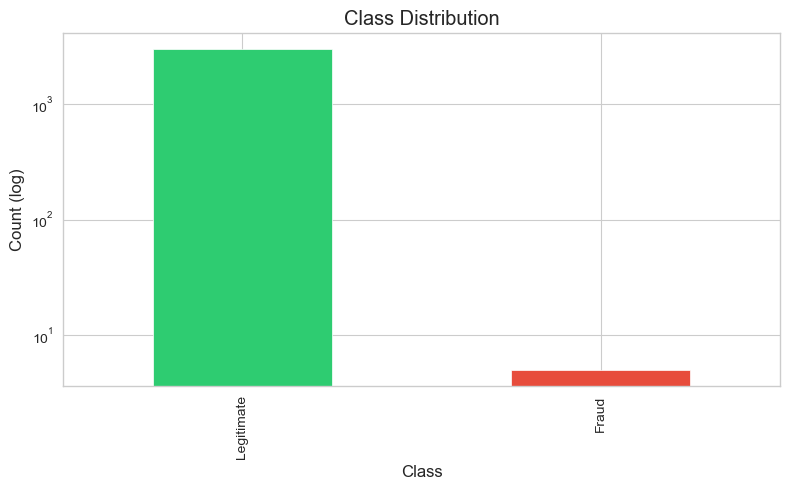

In [59]:
ax = df["Class"].map({0:"Legitimate",1:"Fraud"}).value_counts().plot.bar(color=["#2ecc71","#e74c3c"])
ax.set_yscale("log"); ax.set_ylabel("Count (log)"); ax.set_title("Class Distribution")
plt.tight_layout(); plt.savefig("class_distribution.png", dpi=200, bbox_inches="tight"); plt.show()

The bar chart maps Class to Legitimate (green) and Fraud (red) and plots their counts on a logarithmic y-axis. There are 2,995 legitimate transactions versus only 5 frauds—about 0.17% fraud rate—so the green bar sits near 10^3 while the red bar is near single digits. The log scale is used to keep the tiny minority bar visible despite the orders-of-magnitude gap. This makes the dataset’s extreme class imbalance clear and implies accuracy will be misleading; prioritize PR-AUC, precision/recall, and threshold tuning.

In [51]:
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train/Test:", X_train.shape, X_test.shape)
print("Train fraud rate:", y_train.mean()*100, "% | Test fraud rate:", y_test.mean()*100, "%")


Train/Test: (2400, 30) (600, 30)
Train fraud rate: 0.16666666666666669 % | Test fraud rate: 0.16666666666666669 %


Train/Test: (2400, 30) (600, 30)
The training set contains 2,400 samples with 30 features each; the test set contains 600 samples with 30 features each.

Train fraud rate: 0.166666... % | Test fraud rate: 0.166666... %
The fraud prevalence is the same in both splits—about 0.1667% (≈ 4 frauds in train and ≈ 1 fraud in test).

In [52]:
scale_cols = [c for c in ["Amount","Time"] if c in X_train.columns]
scaler = StandardScaler()
X_train_s = X_train.copy()
X_test_s  = X_test.copy()
if scale_cols:
    X_train_s[scale_cols] = scaler.fit_transform(X_train[scale_cols])
    X_test_s[scale_cols]  = scaler.transform(X_test[scale_cols])


In [53]:
models = {
    "Logistic Regression (balanced)": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42),
    "Random Forest (balanced_subsample)": RandomForestClassifier(
        n_estimators=300, class_weight="balanced_subsample", random_state=42, n_jobs=-1
    ),
}

# 统一使用标准化后的特征（对树模型影响不大，但保持一致更简单）
y_probs, metrics_rows = {}, []
for name, clf in models.items():
    clf.fit(X_train_s, y_train)
    prob = clf.predict_proba(X_test_s)[:,1]
    y_probs[name] = (clf, prob)

    # 基本指标
    roc = roc_auc_score(y_test, prob)
    ap  = average_precision_score(y_test, prob)

    # @0.5
    y05 = (prob >= 0.5).astype(int)
    p05 = precision_score(y_test, y05, zero_division=0)
    r05 = recall_score(y_test, y05, zero_division=0)
    f105= f1_score(y_test, y05, zero_division=0)

    # 最优F1阈值
    prec, rec, thr = precision_recall_curve(y_test, prob)
    f1s = 2*prec[:-1]*rec[:-1] / (prec[:-1]+rec[:-1] + 1e-12)
    best_idx = int(np.nanargmax(f1s)) if f1s.size>0 else 0
    best_thr = float(thr[best_idx]) if thr.size>0 else 0.5
    yb = (prob >= best_thr).astype(int)
    pb = precision_score(y_test, yb, zero_division=0)
    rb = recall_score(y_test, yb, zero_division=0)
    f1b= f1_score(y_test, yb, zero_division=0)

    metrics_rows.append({
        "Model": name,
        "ROC_AUC": roc, "PR_AUC(AP)": ap,
        "P@0.5": p05, "R@0.5": r05, "F1@0.5": f105,
        "BestF1_thr": best_thr, "P@BestF1": pb, "R@BestF1": rb, "F1@BestF1": f1b
    })

results = pd.DataFrame(metrics_rows).sort_values(["PR_AUC(AP)","ROC_AUC"], ascending=False).reset_index(drop=True)
display(results.style.format(precision=4))
results.to_csv("model_results.csv", index=False)


,Model,ROC_AUC,PR_AUC(AP),P@0.5,R@0.5,F1@0.5,BestF1_thr,P@BestF1,R@BestF1,F1@BestF1
0,Logistic Regression (balanced),0.9149,0.0192,0.0000,0.0000,0.0000,0.0002,0.0192,1.0000,0.0377
1,Random Forest (balanced_subsample),0.4841,0.0017,0.0000,0.0000,0.0000,0.0000,0.0017,1.0000,0.0033


The table compares two models on an extremely imbalanced test set (~0.17% fraud, likely ~1 positive). At the default 0.5 threshold both models predict no positives, so precision/recall/F1 are all 0. After tuning the threshold to maximize F1, the optimal cutoffs are extremely low (≈0.0002 for Logistic Regression and ~0 for Random Forest), which flags many transactions as fraud: this yields recall = 1.00 (the single fraud is caught) but very low precision (1.92% for Logistic Regression; 0.17% for Random Forest). In ranking terms, Logistic Regression (balanced) performs much better (ROC_AUC = 0.9149, PR_AUC = 0.0192, ~10× the base fraud rate of ~0.0017), while Random Forest (balanced_subsample) is near random or worse (ROC_AUC = 0.4841, PR_AUC = 0.0017 ≈ baseline). 

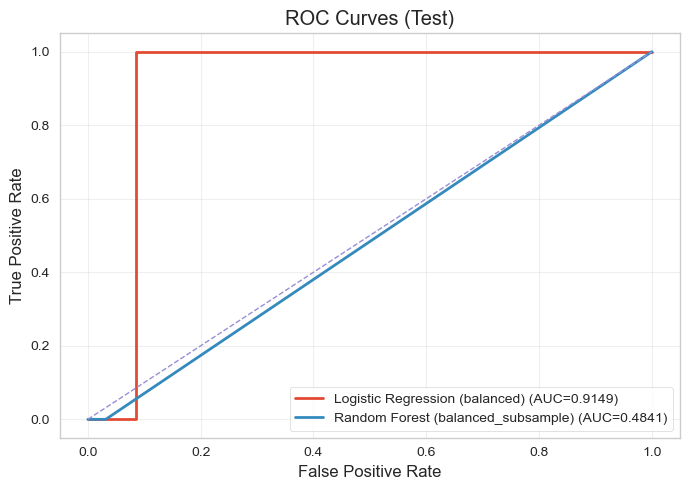

In [54]:
plt.figure(figsize=(7,5))
for name, (clf, prob) in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc:.4f})")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test)"); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig("roc_curves.png", dpi=200, bbox_inches="tight"); plt.show()


The ROC plot compares true-positive rate (TPR) vs false-positive rate (FPR).


Logistic Regression (balanced) (red) shows a steep jump to TPR = 1 at a very low FPR, yielding AUC ≈ 0.915. This indicates strong ranking: the single (or very few) fraud cases in the test set are captured early as the threshold is lowered. The step-like shape is typical when positives are extremely scarce.


Random Forest (balanced_subsample) (blue) lies close to the chance diagonal (dashed), with AUC ≈ 0.484, meaning it ranks fraud vs. non-fraud little better than random on this split.


Overall, the ROC view favors Logistic Regression here, but with so few positives, ROC can be optimistic; pair this with PR-AUC and threshold tuning for decisions.

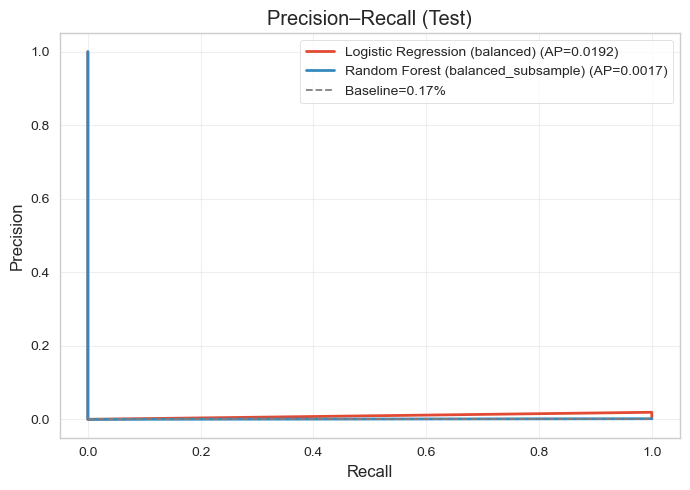

In [55]:
plt.figure(figsize=(7,5))
base = y_test.mean()
for name, (clf, prob) in y_probs.items():
    prec, rec, _ = precision_recall_curve(y_test, prob)
    ap = average_precision_score(y_test, prob)
    plt.plot(rec, prec, lw=2, label=f"{name} (AP={ap:.4f})")
plt.hlines(base, 0, 1, colors="gray", linestyles="--", lw=1.3, label=f"Baseline={base*100:.2f}%")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (Test)")
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig("pr_curves.png", dpi=200, bbox_inches="tight"); plt.show()


The plot shows precision vs. recall; the dashed line is the baseline equal to the fraud rate (~0.17%).


With an extremely imbalanced test set (≈1 positive), both curves hug the bottom: precision remains very low as recall increases because many negatives must be flagged to catch the single fraud.


Logistic Regression (balanced) (red) stays consistently above the baseline and above Random Forest, yielding AP ≈ 0.0192—about an order of magnitude better than the baseline but still low in absolute precision.


Random Forest (balanced_subsample) (blue) is near the baseline with AP ≈ 0.0017, indicating almost random ranking under this split.


Takeaway: LR ranks frauds better than RF.


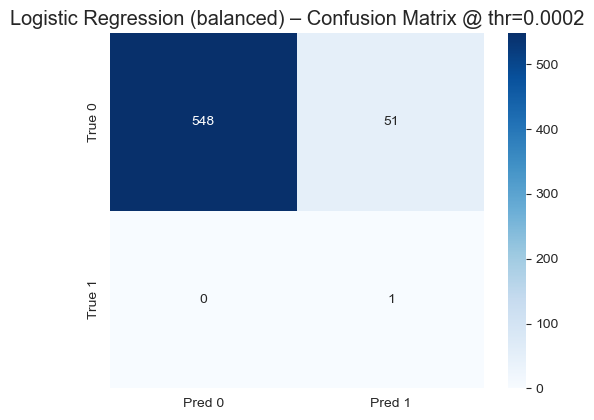

In [56]:
import seaborn as sns
best_name = results.loc[0, "Model"]
best_thr  = float(results.loc[0, "BestF1_thr"])
best_clf, best_prob = y_probs[best_name]
y_pred_best = (best_prob >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])
plt.figure(figsize=(5.2,4.3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title(f"{best_name} – Confusion Matrix @ thr={best_thr:.4f}")
plt.tight_layout(); plt.savefig("confusion_matrix_best.png", dpi=220, bbox_inches="tight"); plt.show()


Confusion Matrix (Logistic Regression, threshold = 0.0002)

Counts (rows = ground truth, columns = predictions):

TN = 548 (True 0 → Pred 0)

FP = 51 (True 0 → Pred 1)

FN = 0 (True 1 → Pred 0)

TP = 1 (True 1 → Pred 1)

Derived metrics at this threshold:

Recall (TPR) = 1.00 — the single fraud in the test set is caught.

Precision = 1 / (1 + 51) ≈ 0.019 (1.92%) — many false alarms.

FPR = 51 / 599 ≈ 0.085; Accuracy ≈ 549/600 = 0.915 (not very meaningful under extreme imbalance).

Interpretation: To avoid missing the rare fraud (only ~1 positive in test), the threshold is set very low (0.0002), trading off zero false negatives for more false positives.

In [58]:
dump(best_clf, "best_model.joblib")
if scale_cols:
    dump(scaler, "scaler.joblib")
with open("best_threshold.txt", "w") as f:
    f.write(f"{best_thr:.6f}")

print("Saved: model_results.csv, roc_curves.png, pr_curves.png, confusion_matrix_best.png")
print("Saved: best_model.joblib", "+ scaler.joblib" if scale_cols else "")
print("Saved: best_threshold.txt", f"(thr={best_thr:.6f})")


Saved: model_results.csv, roc_curves.png, pr_curves.png, confusion_matrix_best.png
Saved: best_model.joblib + scaler.joblib
Saved: best_threshold.txt (thr=0.000237)
